Epoch 1, Loss: 1.3182
Epoch 2, Loss: 0.9360
Epoch 3, Loss: 0.6844
Epoch 4, Loss: 0.9527
Epoch 5, Loss: 0.5241


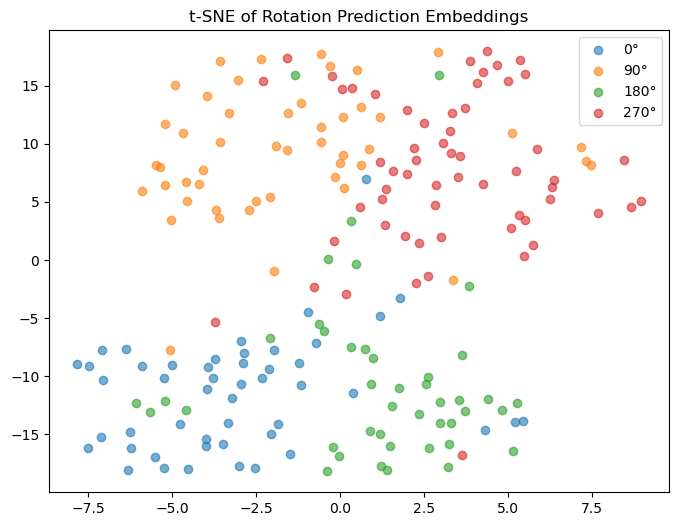

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random

# Define dataset with rotation prediction task
class RotationDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.rotation_angles = [0, 90, 180, 270]
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, _ = self.base_dataset[idx]
        angle_idx = random.randint(0, 3)
        rotated_img = transforms.functional.rotate(img, self.rotation_angles[angle_idx])
        return self.transform(rotated_img), angle_idx

# Simple MLP for rotation classification
class RotationPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 4)
        )
    def forward(self, x):
        return self.net(x)

# Load and prepare data
base_dataset = datasets.MNIST(root='./data', train=True, download=True)
subset = Subset(base_dataset, list(range(200)))  # Small subset for t-SNE
dataset = RotationDataset(subset)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Model setup
model = RotationPredictor()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training loop
for epoch in range(5):
    for x, y in loader:
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Extract embeddings for t-SNE
features, labels = [], []
with torch.no_grad():
    for x, y in loader:
        out = model.net[:-1](x.view(x.size(0), -1))  # Use hidden layer before last
        features.append(out)
        labels.append(y)
features = torch.cat(features).numpy()
labels = torch.cat(labels).numpy()

# t-SNE visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb2d = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
for i, label in enumerate([0, 1, 2, 3]):
    idxs = labels == label
    plt.scatter(emb2d[idxs, 0], emb2d[idxs, 1], label=f"{label * 90}°", alpha=0.6)
plt.legend()
plt.title("t-SNE of Rotation Prediction Embeddings")
plt.show()
